# Heat Pump Emissions Savings for Gas Homes in Black Hills CO Territory under Hourly Grid Emissions Factors

## Goal
In the Black Hills Colorado Gas 2024-2028 Clean Heat Plan that RA supported, one of the utility’s lines of pushback on our analysis was that “given the substantial energy used for space heating, not properly accounting for seasonal power generation emission rates will likely result in a significant over-estimation of electrification GHG benefits.”. We wish to re-calculate the heat pump emissions savings using emissions factors by month-hour and compare this to the savings under flat annual grid emissions factors. Note that unlike with calculating bills, we don’t require the user to provide the "rate structure", since these these time varying emissions factors available from NREL's Cambium. 


## Assumptions
- Universe of households: Single Family Occupied Homes in the Black Hills Colorado Electric utility territory without a heat pump in baseline, according to 2024.2 ResStock. One important caveat is that this is a overestimate of the number of households since we include all relevant households in any county that Black Hills Colorado Electric serves according to [EIA Form 861](https://www.eia.gov/electricity/data/eia861/), when in reality there will be households in some of these counties served by other utilities. 
- Upgrades: Medium Efficiency Heat Pump
- Emissions Factors:
  - Electricity: We assume the following emissions scenario for the state of Colorado pulled from [NREL's Cambium 2022 dataset](https://data.nrel.gov/submissions/206): long run marginal electricity emissions factors considering pre- and post-combustion (CO2e) over 15 years with a 3% discount rate, under the scenario of 95% grid decarbonization by 2050 starting in 2025. We consider both flat emissions factors (constant for the whole year) and time varying emissions factors (by month, hour).
  - Fossil Fuels: Standard flat emissions factors, which the same across all states and all hours. 


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from itertools import chain
import sys
import pyspark.sql.functions as F
import numpy as np
import pandas as pd
import pathlib

sys.path.append("../src")

from rates.modeled_rate import ModeledRate, compute_total_energy_costs, compute_savings
from rates.rate_structure import FlatRateSchedule, EmissionsSchedule
from rates.utility_selector_functions import create_electric_utility_widget, select_county_geoids_in_utility

In [0]:
spark.conf.set("spark.databricks.io.cache.enabled", "true")

In [0]:
BASELINE_UPGRADE_ID = 0.01
HP_UPGRADE_ID = 11.07

## Define Geography of Interest



In [0]:
# Create widget for selecting electric utility, in this case pre-populated with correct values
# so this notebook can run without intervention, but in most cases can widget call with no args
selector = create_electric_utility_widget(state_default='CO', utility_default='Black Hills Colorado Electric, LLC')

In [0]:
# Counties that Black Hills Colorado Electric, LLC serves according for EIA Form 861 for 2023
black_hills_co_county_geoids = select_county_geoids_in_utility(selector)

Counties in Black Hills Colorado Electric, LLC: ['CROWLEY', 'CUSTER', 'EL PASO', 'FREMONT', 'OTERO', 'PUEBLO', 'TELLER']


## Pull in Load Profiles

In [0]:
# Pull timeseries for upgrades of interest
building_load_profiles = (
    spark.table("building_model.resstock_ra_outputs_hourly")
    .where(F.col("upgrade_id").isin([BASELINE_UPGRADE_ID, HP_UPGRADE_ID]))
    # Note: Filtering by county when reading the hourly data makes this much faster!
    # Other building characteristics can be filtered for when joining with the building metadata.
    .where(F.col("county_geoid").isin(black_hills_co_county_geoids))
    .where(F.col("building_set") == "ResStock 2024.2")
    .select(
        "building_id",
        "upgrade_id",
        "day",
        "month",
        "hour",
        F.col("out_electricity_total_energy_consumption_kwh").alias("electricity_kwh"),
        F.col("out_natural_gas_total_energy_consumption_kwh").alias("natural_gas_kwh"),
        F.col("out_propane_total_energy_consumption_kwh").alias("propane_kwh"),
        F.col("out_fuel_oil_total_energy_consumption_kwh").alias("fuel_oil_kwh"),
    )
)

In [0]:
# filter building ids to buildings of interest
filtered_building_ids = (
    spark.table("building_model.resstock_metadata_2024_2")
    .where(F.col("in_geometry_building_type_acs").startswith("Single"))
    .where(~F.col("in_is_vacant"))
    .where(F.col("in_heating_fuel") == "Natural Gas")
    .where(F.col("county_geoid").isin(black_hills_co_county_geoids))
).select("building_id")

In [0]:
# subset load profiles to buildings of interest and load into memory -- takes ~1 min
filtered_building_load_profiles = building_load_profiles.join(F.broadcast(filtered_building_ids), on="building_id")

load_profiles_pd = filtered_building_load_profiles.select(
    F.col("upgrade_id").cast("float"),
    "building_id",
    "day",
    "month",
    "hour",
    "electricity_kwh",
    "natural_gas_kwh",
    "propane_kwh",
    "fuel_oil_kwh",
).toPandas()

In [0]:
# no fuel oil usage for any of these buildings so we can ignore
print(load_profiles_pd[load_profiles_pd.upgrade_id == BASELINE_UPGRADE_ID].fuel_oil_kwh.sum())

# no propane usage for any of these buildings so we can ignore
print(load_profiles_pd[load_profiles_pd.upgrade_id == BASELINE_UPGRADE_ID].propane_kwh.sum())

0.0
0.0


## Pull In Emissions Factors

In [0]:
# read in time varying electric emissions in kg CO2e/kwh by month, year for CO in long hour format
electric_emissions_by_month_hour = (
    spark.table("emissions.cambium_by_month_hour").where(F.col("state") == "CO").toPandas()
)
# pivot to wide format with one row for each hour
electric_emissions_by_month_hour_wide = electric_emissions_by_month_hour.pivot(
    index="month", columns="hour", values="kg_co2e_per_kwh"
)
# convert to numpy array with shape (month, hour)
emissions_matrix = electric_emissions_by_month_hour_wide.values

In [0]:
# read in constant emissions for CO for each fuel in kg CO2e/kwh
fossil_fuel_emissions = (
    spark.table("emissions.cambium")
    .where(F.col("in_state") == "CO")
    .select("fuel", F.col("emissions_factor").cast("float"))
).toPandas()

# convert to dict of fuel -> emissions factor
fuel_to_emissions_factor = fossil_fuel_emissions.set_index("fuel").to_dict()["emissions_factor"]

## Calculate Emissions



#### Electricity

In [0]:
hourly_emissions_schedule = EmissionsSchedule(emissions_matrix=emissions_matrix)
flat_emissions_schedule = FlatRateSchedule(volumetric_rate=fuel_to_emissions_factor["electricity"])

# Model baseline and HP upgrade under hourly electricity emissions factors
electricity_time_varying = ModeledRate.create_modeled_rate_per_upgrade(
    load_profile_upgrades_df=load_profiles_pd,
    rate_schedule=hourly_emissions_schedule,
    name="Hourly CO Emissions Factors",
)

# Model baseline and HP upgrade under flat electricity emissions factors
electricity_flat = ModeledRate.create_modeled_rate_per_upgrade(
    load_profile_upgrades_df=load_profiles_pd,
    rate_schedule=flat_emissions_schedule,
    name="Flat CO Emissions Factor",
)

#### Natural Gas

In [0]:
flat_gas_emissions_schedule = FlatRateSchedule(volumetric_rate=fuel_to_emissions_factor["natural_gas"])

# Model baseline and HP upgrade under flat gas emissions factors
gas_flat = ModeledRate.create_modeled_rate_per_upgrade(
    load_profile_upgrades_df=load_profiles_pd,
    rate_schedule=flat_gas_emissions_schedule,
    fuel="natural_gas",
    name="Flat CO Emissions Factor",
)

#### Compute bills for each fuel and combine

In [0]:
# compute emissions for each (upgrade, fuel) and combine!
# note that we have to rename the cost column to emissions we are deviating from the standard use case for this tool
# granularity = 'monthly_hourly' -- could change to different granularities
granularity = "annual"

# list of (upgrade_id, ModeledRate) pairs
combined_modeled_rates = list(
    chain(
        electricity_time_varying.items(),
        electricity_flat.items(),
        gas_flat.items(),
    )
)

emissions_by_building_upgrade_fuel_rate = pd.concat(
    [
        model.to_long_format(upgrade_id=float(upgrade_id), granularity=granularity)
        for upgrade_id, model in combined_modeled_rates
    ]
)

# NOTE: cost here actually refers to emissions-- we'll rename it soon!
emissions_by_building_upgrade_fuel_rate.head()

,building_id,energy,cost,upgrade_id,fuel,rate_name
0,46994,7276.417,1250.790798,0.01,electricity,Hourly CO Emissions Factors
1,80580,10782.522,1869.324442,0.01,electricity,Hourly CO Emissions Factors
2,101462,11172.454,2021.398252,0.01,electricity,Hourly CO Emissions Factors
3,160220,12403.413,2213.357577,0.01,electricity,Hourly CO Emissions Factors
4,390965,9481.987,1635.899052,0.01,electricity,Hourly CO Emissions Factors


## Results!

In [0]:
# Compute totals over all fuels
total_emissions_by_building_upgrade_rate = compute_total_energy_costs(emissions_by_building_upgrade_fuel_rate)

# Calculate the savings across all fuels under each emissions rate
savings_by_building_upgrade_rate = compute_savings(
    total_emissions_by_building_upgrade_rate, baseline_upgrade_id= BASELINE_UPGRADE_ID
)

# In this case we only care about savings in which both based and the upgrade are using the same emissions rate, so we can remove the other combinations
savings_by_building_upgrade_rate = savings_by_building_upgrade_rate[savings_by_building_upgrade_rate.rate_name_baseline == savings_by_building_upgrade_rate.rate_name]

# Rename columns: replace "cost" with "emissions"
savings_by_building_upgrade_rate.columns = savings_by_building_upgrade_rate.columns.str.replace('cost', 'emissions_kg_co2e')

savings_by_building_upgrade_rate.head()

,building_id,energy,emissions_kg_co2e,upgrade_id,rate_name,energy_baseline,emissions_kg_co2e_baseline,rate_name_baseline,energy_savings,emissions_kg_co2e_savings,has_positive_savings
0,46994,16426.546623,3440.245387,11.07,Hourly CO Emissions Factors,37208.241603,8074.625061,Hourly CO Emissions Factors,20781.694980,4634.379674,True
3,46994,16426.546623,3122.636422,11.07,Flat CO Emissions Factor,37208.241603,8151.082780,Flat CO Emissions Factor,20781.694980,5028.446358,True
4,80580,15368.118302,3116.907175,11.07,Hourly CO Emissions Factors,22546.663272,4551.304286,Hourly CO Emissions Factors,7178.544970,1434.397111,True
7,80580,15368.118302,3026.908305,11.07,Flat CO Emissions Factor,22546.663272,4648.756396,Flat CO Emissions Factor,7178.544970,1621.848091,True
8,101462,22679.697481,4776.060415,11.07,Hourly CO Emissions Factors,58664.420918,12848.580202,Hourly CO Emissions Factors,35984.723437,8072.519786,True


array([<Axes: title={'center': 'Flat CO Emissions Factor'}>,
       <Axes: title={'center': 'Hourly CO Emissions Factors'}>],
      dtype=object)

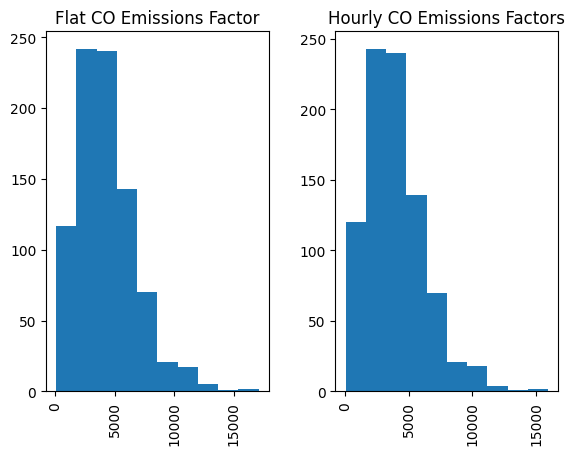

In [0]:
# look at the distributions of emissions savings under each emissions factor assumption -- they dont look very different
savings_by_building_upgrade_rate.hist("emissions_kg_co2e_savings", by="rate_name")

In [0]:
# look at the mean and median emissions and savings under emissions factor assumption for baseline and hp upgrade
# Shocker: even under hourly emissions factors, heat pumps save massively, with an average of just under 400 kg CO2e per household per year
savings_by_building_upgrade_rate.groupby(["upgrade_id", "rate_name"]).agg(
    {
        "emissions_kg_co2e": ["mean", "median"],
        "emissions_kg_co2e_savings": ["mean", "median"],
    }
)

emissions_kg_co2e  ... emissions_kg_co2e_savings
                                                    mean  ...                    median
upgrade_id rate_name                                      ...                          
11.07      Flat CO Emissions Factor          3871.886329  ...               3893.886654
           Hourly CO Emissions Factors       4177.619045  ...               3600.152449

[2 rows x 4 columns]

In [0]:
# Finally, lets directly look at the difference in hp emissions savings under the two assumptions
# We see that accounting for the time varying emissivity of the grid only decreases emisisons savings on average by about 8%, or ~300 kg CO2e per household, and in the worst case by about 21%.
# Pivot to wide format and compute diff

comparison = savings_by_building_upgrade_rate.pivot(
    index="building_id", columns="rate_name", values="emissions_kg_co2e_savings"
)
comparison["Diff"] = comparison["Flat CO Emissions Factor"] - comparison["Hourly CO Emissions Factors"]
comparison["Percent Diff"] = (comparison["Diff"] / comparison["Flat CO Emissions Factor"]) * 100
comparison.describe()

rate_name,Flat CO Emissions Factor,Hourly CO Emissions Factors,Diff,Percent Diff
count,858.000000,858.000000,858.000000,858.000000
mean,4288.422776,3978.279589,310.143187,7.580249
std,2424.068570,2276.895649,162.788441,1.840693
min,66.258879,56.119567,10.139311,1.865527
25%,2609.004690,2386.697006,189.694986,6.259946
50%,3893.886654,3600.152449,290.252396,7.311166
75%,5574.053991,5162.223059,403.305819,8.473543
max,17079.845017,15929.151442,1150.693575,21.147462


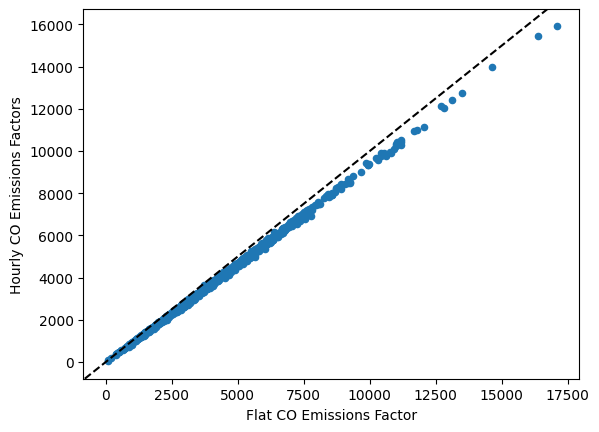

In [0]:
# And lets visualize the per building difference
ax = comparison.plot(x="Flat CO Emissions Factor", y="Hourly CO Emissions Factors", kind="scatter")
ax.axline((0, 0), slope=1, color="k", ls="dashed")